## Lab 10: Final Lab
You can use external libraries for linear algebra operations but you are expected to write your own algorithms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Exercise 1
Implement your own versions of:
- Density peaks clustering (without the halo feature)
- Normalized Mutual Information (NMI)
- F-ratio

In [2]:
from dadapy import Data
from dadapy.plot import plot_DecGraph

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors

Using the ```Aggregation``` dataset available at [this link](https://cs.joensuu.fi/sipu/datasets/) under Shape sets:
1. Use **your own** version of density peaks at several values of the  ```epsilon``` parameter and choose the one that maximises the NMI with the ground truth (third column).

Hint:
As a rule of thumb, ```epsilon``` should be chosen in such a way that, on average, between 1% and 2% of the data points are included in the neighbourhood.
Use the exponential kernel.

In [3]:
agg = np.loadtxt("../Datasets/Aggregation.txt")

In [4]:
print(agg.shape)
print(agg)

(788, 3)
[[15.55 28.65  2.  ]
 [14.9  27.55  2.  ]
 [14.45 28.35  2.  ]
 ...
 [ 8.5   3.25  5.  ]
 [ 8.1   3.55  5.  ]
 [ 8.15  4.    5.  ]]


In [5]:
y = agg[:,2]
X = agg[:,:2]

In [6]:
n_classes = len(np.unique(y))
print(n_classes)

7


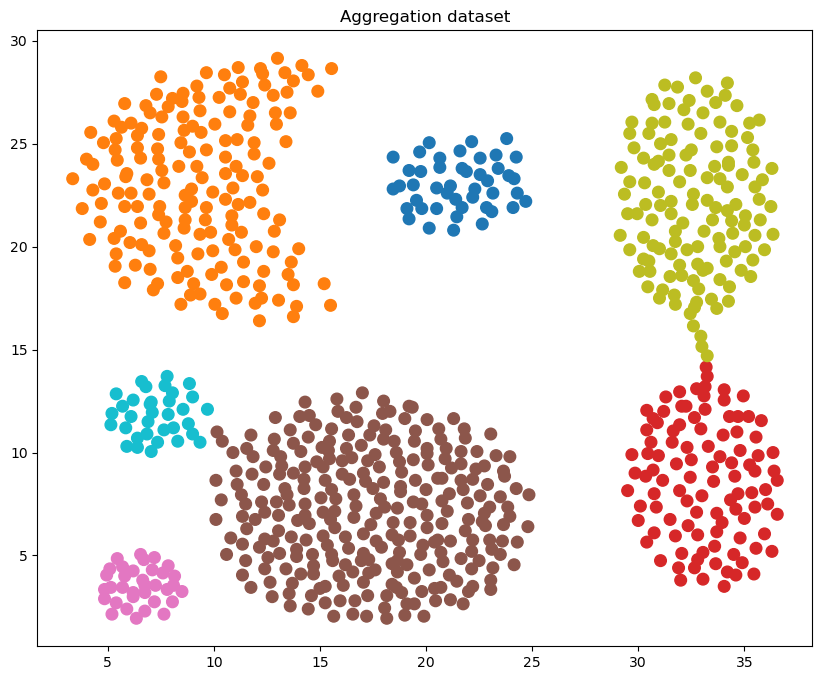

In [7]:
plt.figure(figsize=(10,8))

plt.scatter(X[:,0], X[:,1], c=y, s=70, cmap = "tab10")
plt.title("Aggregation dataset")
plt.show()

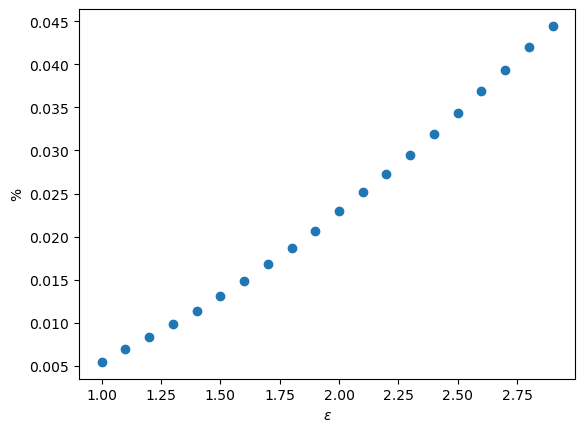

In [ ]:
# the'epsilon' parameter is such that, on average, 1-2% of the points are within the neighbourhood - we can verify it with Nearest Neighbours directly
epsilon_range = np.arange(1,3,0.1)
average=np.zeros(len(epsilon_range))

for i_, epsilon in enumerate(epsilon_range):
    knn = NearestNeighbors(radius = epsilon).fit(X)
    
    n_neighs = knn.radius_neighbors()[0]  #knn.radius_neighbors returns a tuple: the first element is stores one array per datapoint with the distances to all the neighbours within a radius, the second element stores the indices of the same points

    average[i_] = np.mean([len(el) for el in n_neighs])  #to compute the number of neighbours within a ball of radius epsilon we can simply check the lenght of each of the arrays

average = average / X.shape[0]

plt.scatter(epsilon_range, average)
plt.xlabel("$\epsilon$")
plt.ylabel("%")
plt.show()

In [13]:
candidate_eps = epsilon_range[(average>=0.01)*(average<=0.02)] #find good candidates for the 'epsilon' parameters
print(candidate_eps)

[1.4 1.5 1.6 1.7 1.8]


Computation of distances started
Computation of the distances up to 787 NNs started
0.03 seconds for computing distances
Number of points for which self.delta needed call to cdist= 0


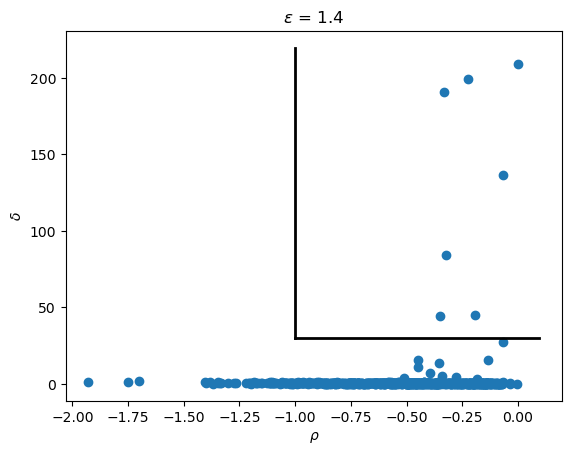

Computation of distances started
Computation of the distances up to 787 NNs started
0.03 seconds for computing distances
Number of points for which self.delta needed call to cdist= 0
Computation of distances started
Computation of the distances up to 787 NNs started
0.03 seconds for computing distances
Number of points for which self.delta needed call to cdist= 0
Computation of distances started
Computation of the distances up to 787 NNs started
0.03 seconds for computing distances
Number of points for which self.delta needed call to cdist= 0
Computation of distances started
Computation of the distances up to 787 NNs started
0.03 seconds for computing distances
Number of points for which self.delta needed call to cdist= 0


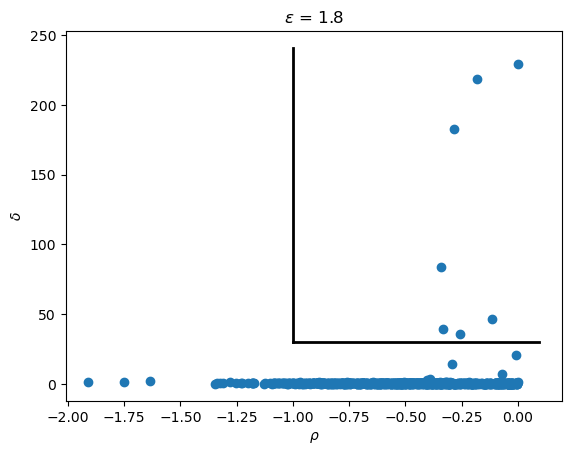

In [ ]:
nmi = []

for epsilon in candidate_eps:
    data = Data(X, verbose=True)
    data.compute_distances(maxk=X.shape[0]-1, metric = 'sqeuclidean') 
    #equivalent to dist(X, X, 'sqeuclidean') but the library requires the values to be ordered wrt the distance, not only by index

    dist_ = np.exp(-data.distances/(epsilon**2))
    rho = np.sum(dist_, axis=1)

    rho = rho/np.max(rho)
    data.log_den = np.log(rho)
    data.compute_DecGraph()

    dens_cut = -1
    delta_cut = 30
            #note that these cutoff points should be tailored for each case! 
            #try to run this code by modifying the values of the cuts for each iteration on 'epsilon' and see if there are sensible changes
            #do you agree on the selection of outliers? Would you have done something different?


    if epsilon in [candidate_eps[0], candidate_eps[-1]]:
        #Let's plot it only for the first and last value of epsilon within our candidates
        plt.xlabel(r"$\rho$")
        plt.ylabel(r"$\delta$")
        plt.scatter(data.log_den, data.delta)
        bottom,up=plt.ylim()
        left,right=plt.xlim()
        plt.plot([dens_cut, dens_cut], [delta_cut, up], color="k", linestyle="-", linewidth=2)
        plt.plot([dens_cut, right], [delta_cut, delta_cut], color="k", linestyle="-", linewidth=2)
        plt.title(f"$\epsilon$ = {np.round(epsilon,2)}")
        plt.show()

                #analyse in detail the results of the graph
        

    dp_labels = data.compute_clustering_DP(dens_cut=dens_cut,delta_cut=delta_cut, halo=False) #find the cluster labels associated to the selected values of rho and delta
    nmi.append(normalized_mutual_info_score(y, dp_labels)) #compute the normalized mutual information between the cluster labels and the ground truth

Let us choose the ```epsilon``` parameter whose clustering maximises the NMI with the ground truth. Run density peaks again and visualize the results before moving to point 2.

In [16]:
eps=candidate_eps[np.argmax(nmi)] #select the 'epsilon' that maximises the NMI in the previous runs
print(eps)

1.4000000000000004


In [17]:
#run the algorithm again, with the select value for 'epsilon'

data = Data(X, verbose=True)
data.compute_distances(maxk=X.shape[0]-1, metric = 'sqeuclidean')

dist_ = np.exp(-data.distances/(eps**2))
rho = np.sum(dist_, axis=1)

rho = rho/np.max(rho)
data.log_den = np.log(rho) 


# using a dadapy-implemented density, you can simply do the following:
# note that the densities estimations of dadapy do not use the exponential kernel which was required for this exercise

# data = Data(X, verbose=True)
# data.compute_distances()
# data.compute_id_2NN()
# data.compute_density_kstarNN() 

Computation of distances started
Computation of the distances up to 787 NNs started
0.04 seconds for computing distances


Number of points for which self.delta needed call to cdist= 0


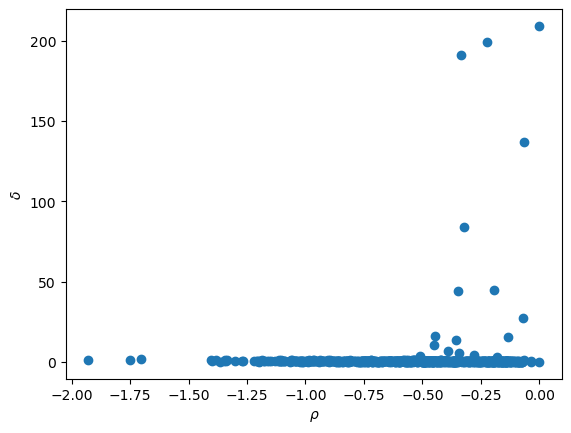

In [18]:
data.compute_DecGraph()
plot_DecGraph(data)

Let us select two different cutoff values and present the results, discuss what you find best suited.

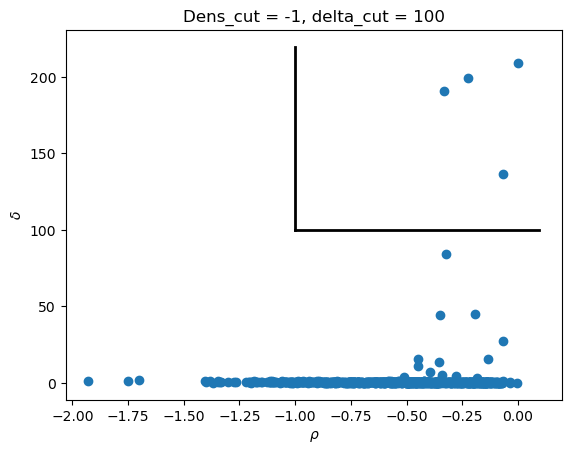

In [19]:
dens_cut = -1
delta_cut = 100

plt.xlabel(r"$\rho$")
plt.ylabel(r"$\delta$")
plt.scatter(data.log_den, data.delta)
bottom,up=plt.ylim()
left,right=plt.xlim()
plt.plot ([dens_cut, dens_cut], [delta_cut, up], color="k", linestyle="-", linewidth=2)
plt.plot ([dens_cut, right], [delta_cut, delta_cut], color="k", linestyle="-", linewidth=2)
plt.title(f"Dens_cut = {dens_cut}, delta_cut = {delta_cut}")
plt.show()

dp_labels_1 = data.compute_clustering_DP(dens_cut=dens_cut,delta_cut=delta_cut, halo=False)

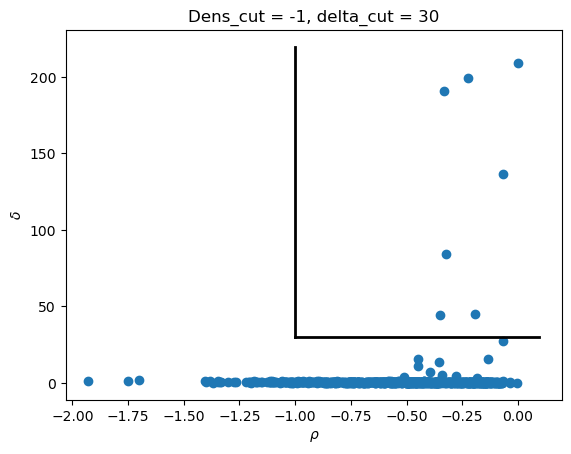

In [20]:
dens_cut = -1
delta_cut = 30

plt.xlabel(r"$\rho$")
plt.ylabel(r"$\delta$")
plt.scatter(data.log_den, data.delta)
bottom,up=plt.ylim()
left,right=plt.xlim()
plt.plot ([dens_cut, dens_cut], [delta_cut, up], color="k", linestyle="-", linewidth=2)
plt.plot ([dens_cut, right], [delta_cut, delta_cut], color="k", linestyle="-", linewidth=2)
plt.title(f"Dens_cut = {dens_cut}, delta_cut = {delta_cut}")
plt.show()

dp_labels_2 = data.compute_clustering_DP(dens_cut=dens_cut,delta_cut=delta_cut, halo=False)

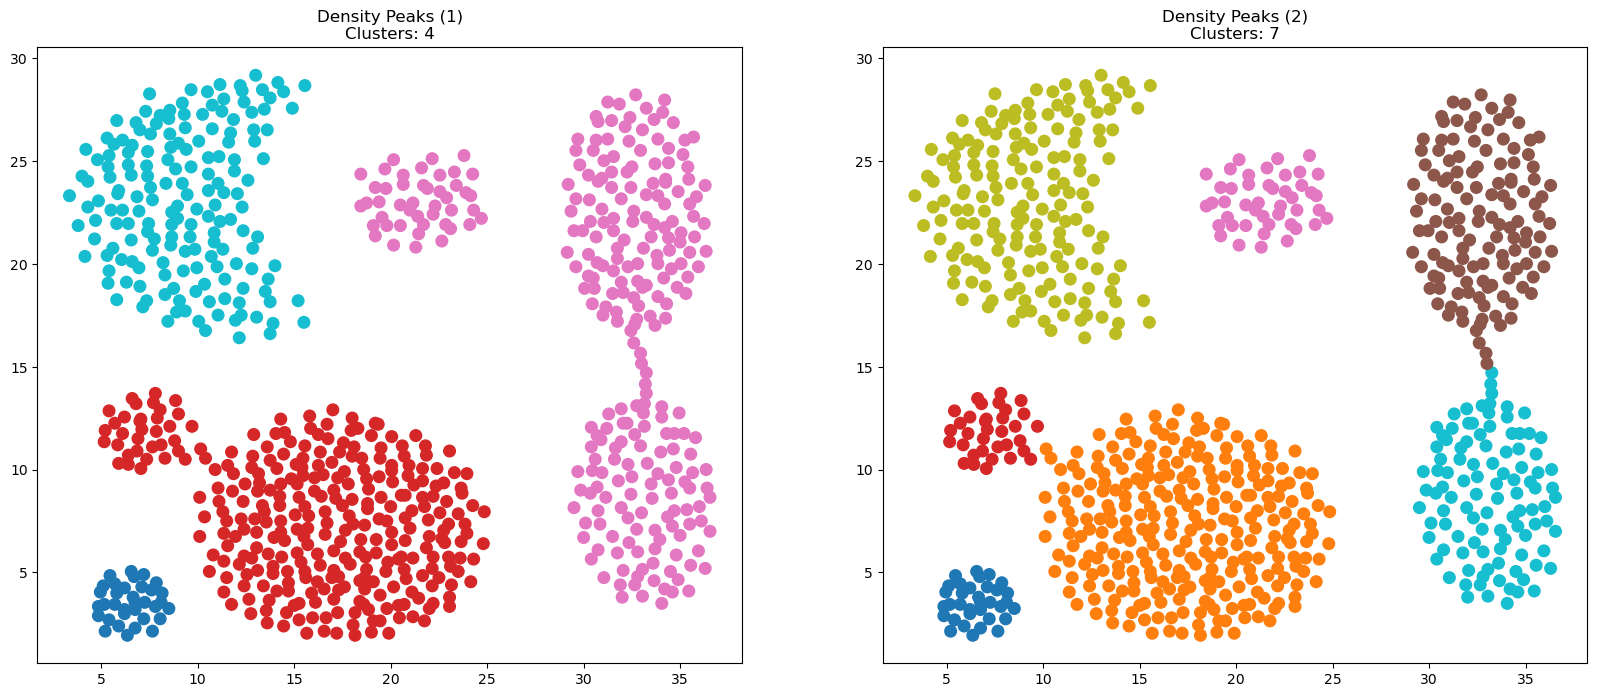

In [23]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].scatter(X[:,0], X[:,1], c=dp_labels_1, s=70, cmap="tab10")
ax[0].set_title(f"Density Peaks (1)\nClusters: {len(np.unique(dp_labels_1))}")

ax[1].scatter(X[:,0], X[:,1], c=dp_labels_2, s=70, cmap = "tab10")
ax[1].set_title(f"Density Peaks (2)\nClusters: {len(np.unique(dp_labels_2))}")
plt.show()

2. Compute the NMI with the ground truth and the F-ratio test for this assignation.

Note: have a look at [this](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.cluster) documentation page for more cluster validation measures implemented in sklearn.

In [25]:
print(f"NMI of density peaks - version 1: {normalized_mutual_info_score(y, dp_labels_1)}")
print(f"NMI of density peaks - version 2: {normalized_mutual_info_score(y, dp_labels_2)}")

NMI of density peaks - version 1: 0.8295897974024589
NMI of density peaks - version 2: 0.9956972087142976


In [26]:
def F_ratio(X, labels): #not implemented in sklearn
    '''
    Computes the F-ratio variance test (WB-index), defined as:
    F = k*W / B

    having  k: the number of clusters
            W: the within cluster variance (sum_{i}^{N} ||x_i - c_p(i)||^2)
            B: the between cluster variance (sum_{j}^{k} n_j * ||c_j - x_bar||^2)
    '''

    k = len(np.unique(labels)) #number of clusters

    W, B = 0.0, 0.0
    X_mean = np.mean(X, axis=0)

    for k_id in range(k):
        cluster_k = X[labels==k_id]
        mean_k = np.mean(cluster_k, axis=0)

        W += np.sum((cluster_k - mean_k)**2)
        B += len(cluster_k)*np.sum((mean_k - X_mean)**2)

        
    if B == 0:
        return None
    
    return k*W / B

In [28]:
print(f"F-ratio of density peaks - version 1: {F_ratio(X, dp_labels_1)}")
print(f"F-ratio of density peaks - version 2: {F_ratio(X, dp_labels_2)}")

F-ratio of density peaks - version 1: 1.3866331484060241
F-ratio of density peaks - version 2: 0.757968504717392


3. Perform $k$-means with $k$ equal to the true number of clusters, compute the NMI with the ground truth and the F-ratio test.

In [29]:
from sklearn.cluster import KMeans

In [30]:
kmeans = KMeans(n_clusters=n_classes) #init='k-means++', n_init=1
kmeans.fit(X)

KMeans(n_clusters=7)

In [31]:
km_labels = kmeans.labels_

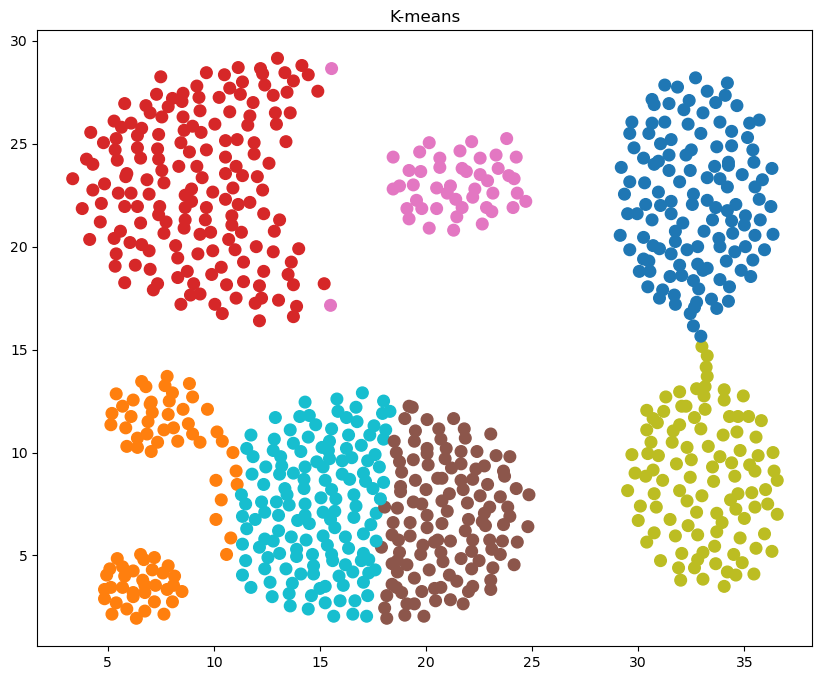

In [32]:
plt.figure(figsize=(10,8))

plt.scatter(X[:,0], X[:,1], c=km_labels, s=70, cmap="tab10")
plt.title("K-means")
plt.show()

In [33]:
print(f"NMI of k-means: {normalized_mutual_info_score(y, km_labels)}")

NMI of k-means: 0.8792390052708805


In [34]:
print(f"F-ratio of k-means: {F_ratio(X, dp_labels_1)}")

F-ratio of k-means: 1.3866331484060241


4. Apply the ```sklearn``` implementation of DBSCAN and MeanShift to the dataset. Discuss the differences among the obtained results.

In [35]:
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth

Note: setting the hyperparameters of these methods is not at all easy (no rule of thumb unfortunately). We propose some results (obtained via a trial and error approach): which hyperparameters seems to best fit the problem?

For DBSCAN, when you see ```Derived n_clust = 0``` it means that all points are assigned the label ```-1``` which is the one corresponding to the noise (colored in tab:blue in the plots below).

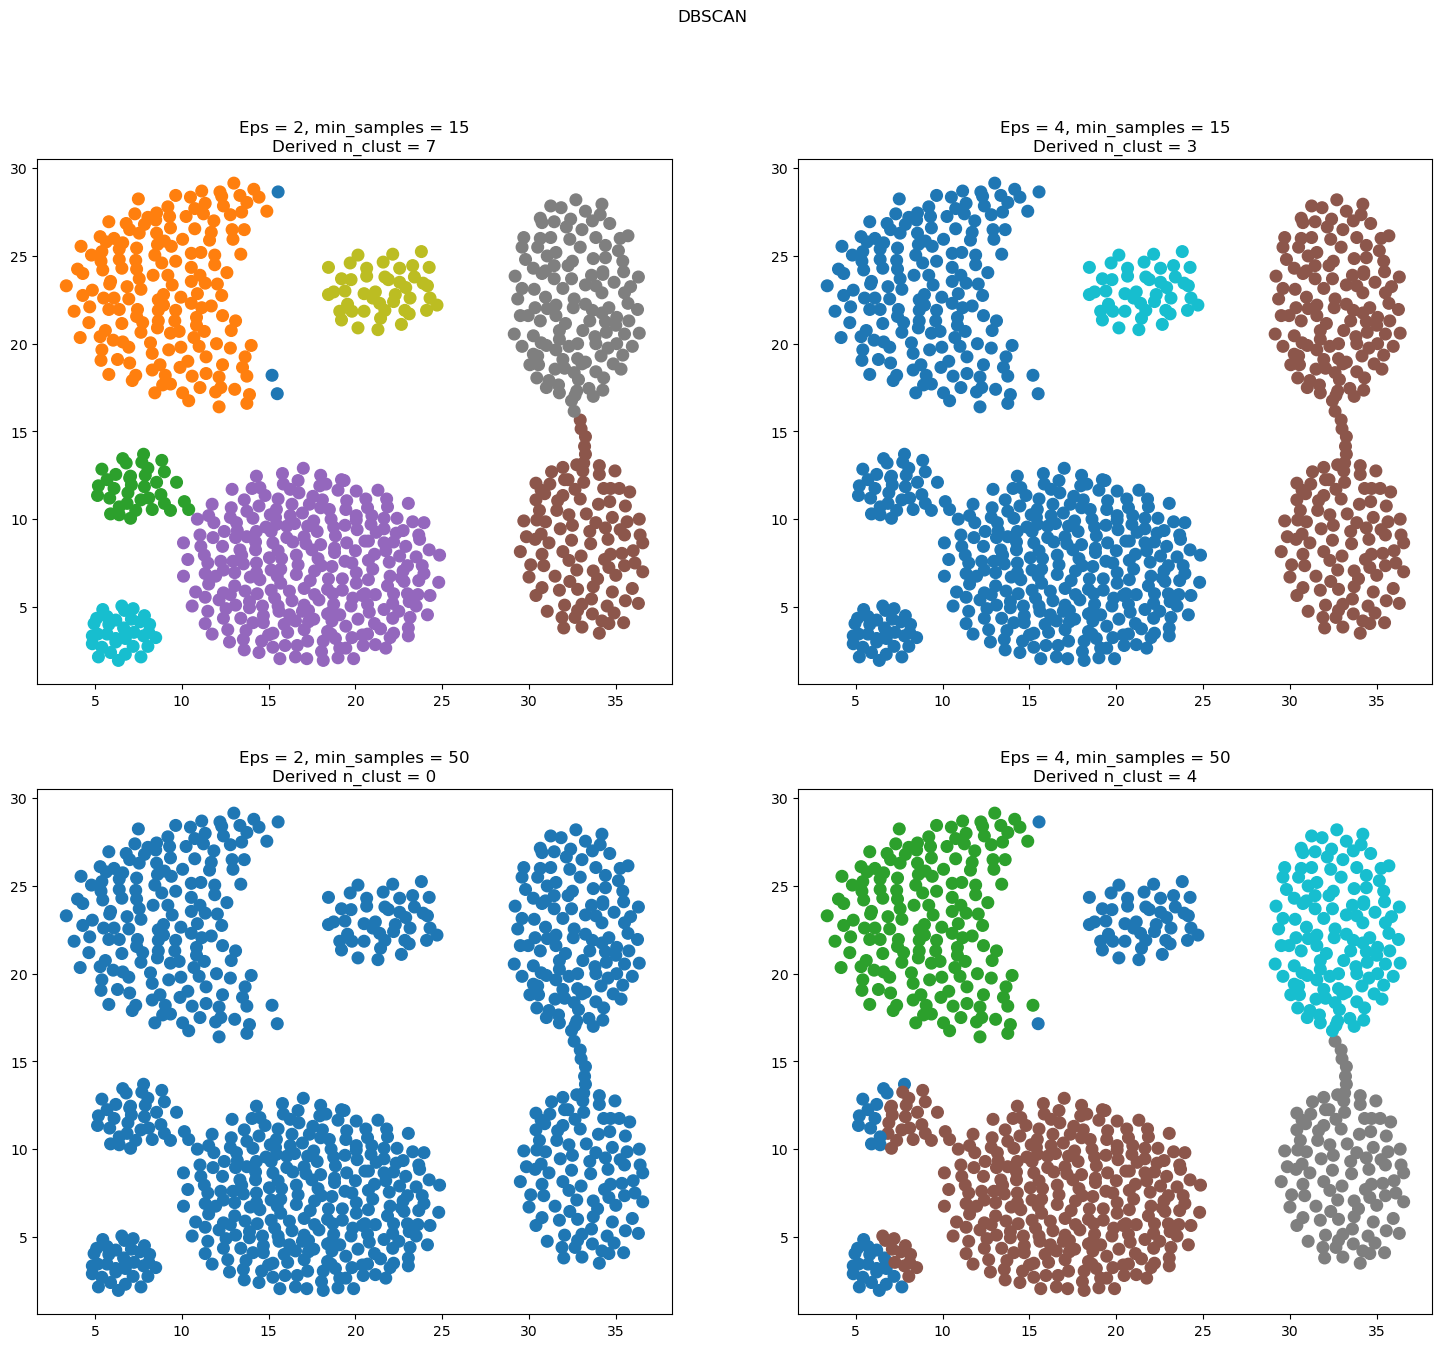

In [36]:
fig, ax = plt.subplots(2,2, figsize=(18,15))

for i, (eps, min_samples) in enumerate([(2, 15),(4, 15),(2, 50),(4, 50)]):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)
    dbs_labels = dbscan.labels_

    ax_ = ax[i//2, i%2]

    ax_.scatter(X[:,0], X[:,1], c=dbs_labels, s=70, cmap="tab10")
    ax_.set_title(f"Eps = {eps}, min_samples = {min_samples}\nDerived n_clust = {np.max(dbs_labels)+1}")

plt.suptitle("DBSCAN")
plt.show()

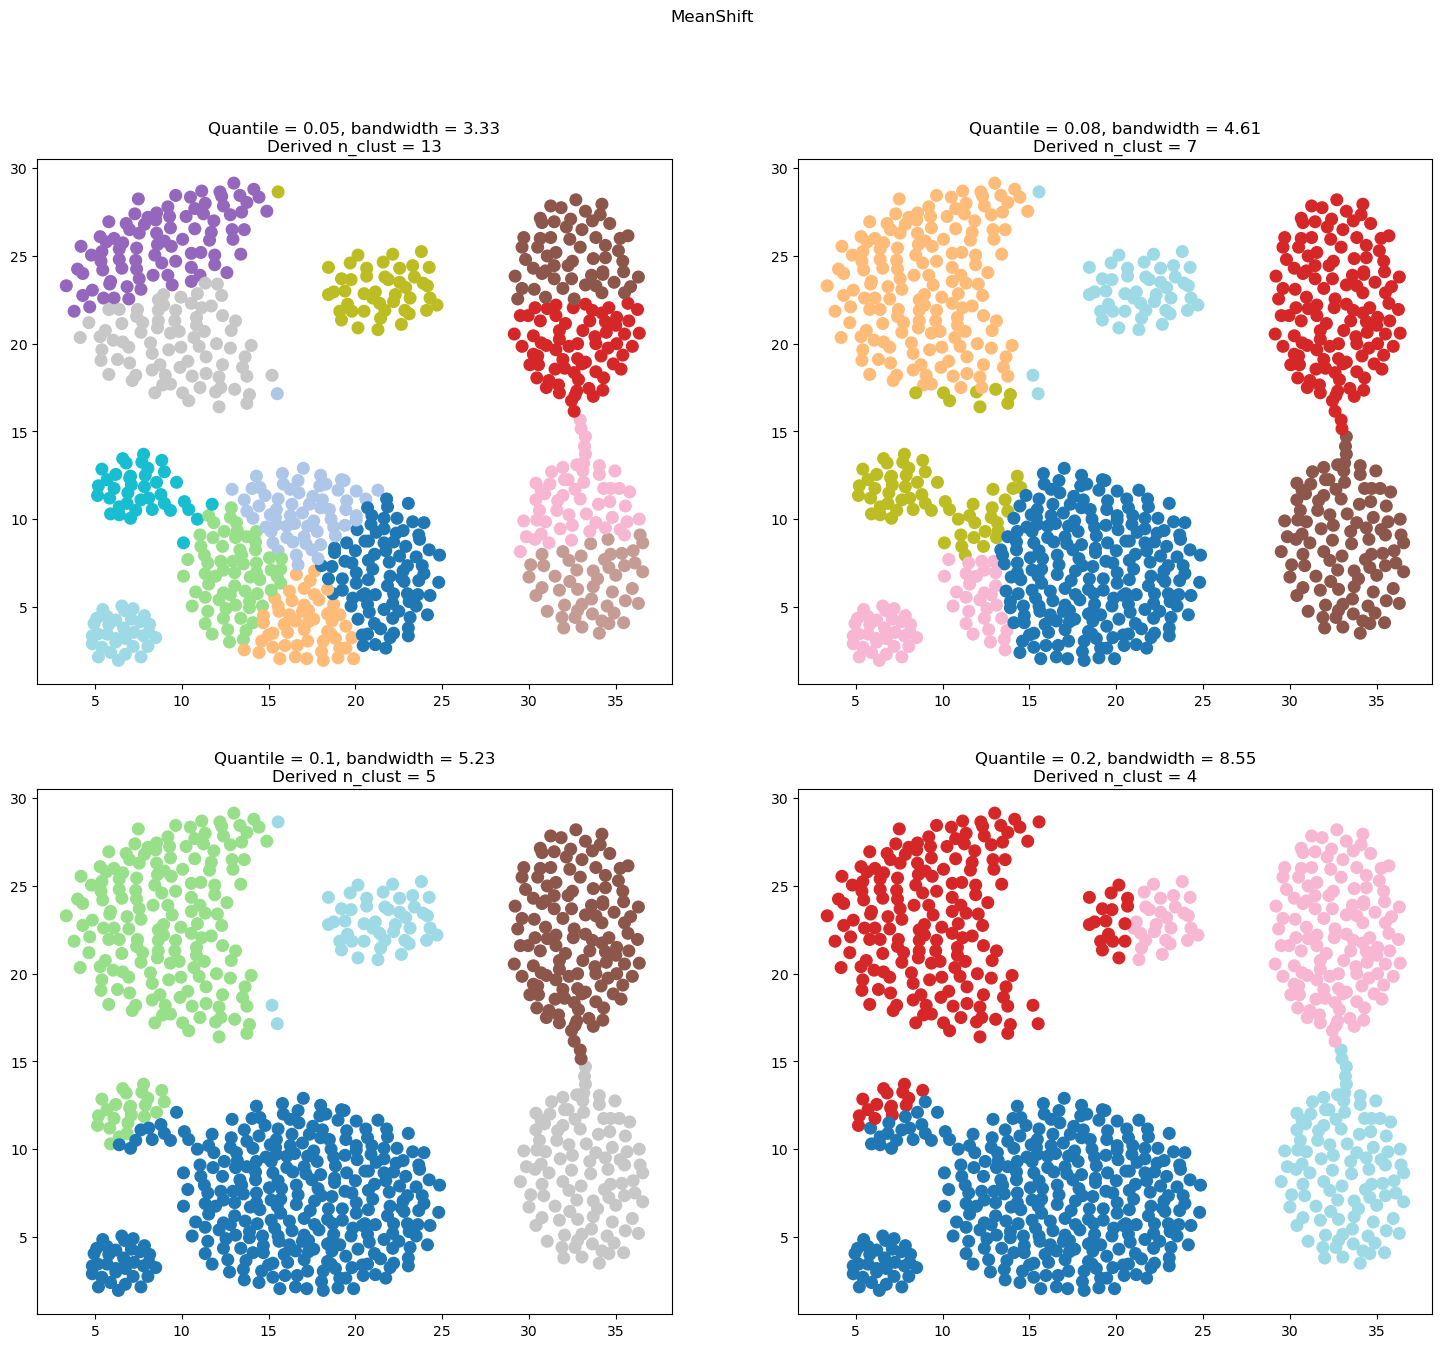

In [38]:
fig, ax = plt.subplots(2,2, figsize=(18,15))

for i, quantile in enumerate([0.05, 0.08, 0.1, 0.2]):
    bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=X.shape[0]) 
    
    meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)  #here you can set the 'bandwidth' parameter direcly, but we relied on its estimation
    meanshift.fit(X)

    ms_labels = meanshift.labels_
    ax_ = ax[i//2, i%2]

    ax_.scatter(X[:,0], X[:,1], c=ms_labels, s=70, cmap="tab20")
    ax_.set_title(f"Quantile = {quantile}, bandwidth = {np.round(bandwidth,2)}\nDerived n_clust = {np.max(ms_labels)+1}")

plt.suptitle("MeanShift")
plt.show()